# Getting Data

First, we want to grab some graphs and subject covariates from a web-accessible url.  We've given this to you on google drive rather than having you set up aws s3 credentials in the interest of saving time. The original data is hosted at m2g.io

Below, you will be getting the following dataset:

| Property | Value |
|:--------:|:-----:|
| Dataset  | SWU4  |
| N-Subjects  | 454   |
| Scans-per-subjects | 2 |
| Atlases | Desikan, CPAC200 |
| Desikan Nodes | 70 |
| CPAC200 Nodes | 200 |

The covariates you have are: `SUBID, SESSION, AGE_AT_SCAN_1, SEX, RESTING_STATE_INSTRUCTION, TIME_OF_DAY, SEASON, SATIETY, LMP`. There are other columns in the `.csv` file (downloaded in the next step) but they are populated with a `#` meaning that the value was not recorded.

There are several other atlases available - you can change which one you use 
Running the cell below will get you the data. **Please note, you only have to run these two cells once!!!**

## Loading Graphs + Covariates
Run the following cells of code to load the graphs into your computer, as well as the covariates.

In [245]:
!pip install networkx==1.9 #networkx broke backwards compatibility with these graph files
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import os
import csv
import networkx.algorithms.centrality as nac


from collections import OrderedDict

In [246]:
# Initializing dataset names
dataset_names = ('SWU4')

basepath = 'data'

# change which atlas you use, here!

atlas = 'desikan' # 'desikan' # or 'CPAC200', or 'Talairach'
dir_names = basepath + '/' + dataset_names + '/' + atlas
#basepath = "/"
#dir_names = basepath
print(dir_names)
fs = OrderedDict()
fs[dataset_names] = [root + "/" + fl for root, dirs, files in os.walk(dir_names)
                     for fl in files if fl.endswith(".gpickle")]

ps = "data/SWU4/SWU4.csv"

print("Datasets: " + ", ".join([fkey + " (" + str(len(fs[fkey])) + ")"
                                for fkey in fs]))
print("Total Subjects: %d" % (sum([len(fs[key]) for key in fs])))

data/SWU4/desikan
Datasets: SWU4 (454)
Total Subjects: 454


In [247]:
def loadGraphs(filenames, verb=False):
    """
    Given a list of files, returns a dictionary of graphs

    Required parameters:
        filenames:
            - List of filenames for graphs
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Initializes empty dictionary
    gstruct = OrderedDict()
    for idx, files in enumerate(filenames):
        if verb:
            print("Loading: " + files)
        #  Adds graphs to dictionary with key being filename
        fname = os.path.basename(files)
        gstruct[fname] = nx.read_gpickle(files)
    return gstruct

def constructGraphDict(names, fs, verb=False):
    """
    Given a set of files and a directory to put things, loads graphs.

    Required parameters:
        names:
            - List of names of the datasets
        fs:
            - Dictionary of lists of files in each dataset
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Loads graphs into memory for all datasets
    graphs = OrderedDict()
    if verb:
        print("Loading Dataset: " + names)
    # The key for the dictionary of graphs is the dataset name
    graphs[names] = loadGraphs(fs[names], verb=verb)
    return graphs

In [248]:
graphs = constructGraphDict(dataset_names, fs, verb=False)

In [249]:
import csv
# This gets age and sex, respecitvely.
tmp = csv.reader(open(ps,newline='')) # this is the whole phenotype file
pheno = OrderedDict()
triple = [[t[0].strip(), t[2], int(t[3] == '2')] for t in tmp
          if t[3] != '#' and t[2] != '#'][1:]  # female=1->0, male=2->1

for idx, trip in enumerate(triple):
    pheno[trip[0]] = trip[1:]

In [250]:
## replace with this

k = sorted(list(graphs['SWU4'].keys()))
k_id = list(key[6:11] for key in k)
k_id = k_id[0::2]
k_g1 = k[0::2]

g1 = []
for xx in k_g1:
    g1.append(graphs['SWU4'][xx])

#Create vectors of labels
age = list()
sex = list()

for key in k_id:
    sex.append(pheno[key][1])
    age.append(pheno[key][0])      

## ASSIGNMENT:  
(Code above used to get data in the correct format.  Below is a simple example test string with kind of silly features)

In [251]:
#Combine features, separate training and test data

X = []
for i in range(len(g1)):
    featvec = []
    
    matrix = nx.to_numpy_matrix(g1[i], nodelist=sorted(g1[i].nodes())) #this is how you go to a matrix
    
    logmatrix = np.log10(np.sum(matrix,0) + 1)
    logmatrix = np.ravel(logmatrix)
    
    covariate1 = nx.degree_centrality(g1[i])
    covariate1 = covariate1.values()
    
    covariate2 = nac.betweenness_centrality(g1[i])
    covariate2 = covariate2.values()
    #dict
    
    covariate3 = nx.average_clustering(g1[i])
    covariate3 = np.ravel(covariate3)
    #float
    
    covariate4 = nac.closeness_centrality(g1[i])
    covariate4 = covariate4.values()
    #dict
    
    covariate5 = nac.eigenvector_centrality(g1[i])
    covariate5 = covariate5.values()
    #dict

        
    for ii in logmatrix:
        featvec.append(ii)
    for iii in covariate1:
        featvec.append(iii)
    for iv in covariate2:
        featvec.append(iv)
    for v in covariate3:
        featvec.append(v)
    for vi in covariate4:
        featvec.append(vi)
    for vii in covariate5:
        featvec.append(vii)
    

    xsum = np.asarray(np.sum(matrix))
    featvec.append(xsum)
    np.shape(featvec)
    X.append(featvec)

In [255]:
X_train = X[0:100]
Y_train = sex[0:100]

X_test = X[100:200]
Y_test = sex[100:200]

from sklearn.ensemble import RandomForestClassifier
accuracy = []
for ii in range(10): #performance will change over time
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, Y_train)
    acc = (clf.predict(X_test) == Y_test)
    #print(acc)
    accval = (float(np.sum(acc))/float(len(Y_test)))
    accuracy.append(accval)
    print('Accuracy:',accval)

print('Overall Accuracy:',str(np.mean(accuracy)))

Accuracy: 0.62
Accuracy: 0.65
Accuracy: 0.61
Accuracy: 0.64
Accuracy: 0.6
Accuracy: 0.62
Accuracy: 0.59
Accuracy: 0.62
Accuracy: 0.63
Accuracy: 0.62
Overall Accuracy: 0.62


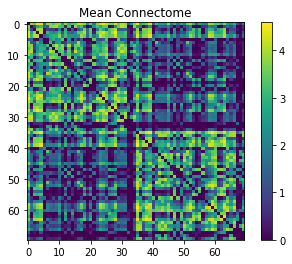

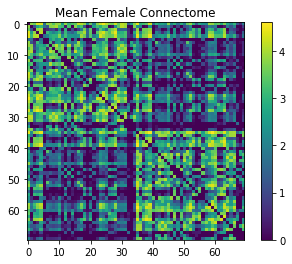

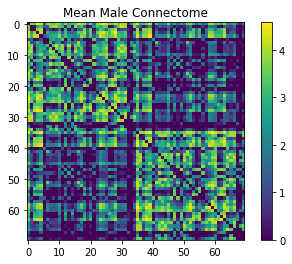

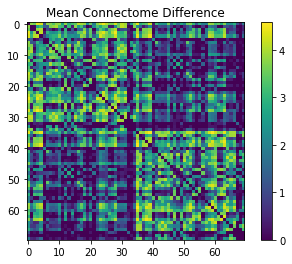

In [256]:
# plot a graph
import matplotlib.pyplot as plt
%matplotlib inline

# mean connectome
matrix = np.zeros([70, 70])
n = 0
for i in range(len(g1)):
    matrix += nx.to_numpy_matrix(g1[i], nodelist=sorted(g1[i].nodes())) #this is how you go to a matrix
    n += 1

matrix /= n

plt.imshow(np.log10(matrix+1))
plt.colorbar()
plt.title('Mean Connectome')
plt.show()

# mean female connectome
matrix = np.zeros([70, 70])
n = 0
for i in range(len(g1)):
    if sex[i] == 0:
        matrix += nx.to_numpy_matrix(g1[i], nodelist=sorted(g1[i].nodes())) #this is how you go to a matrix
        n += 1

matrix /= n

mFC = nx.DiGraph(matrix)

plt.imshow(np.log10(matrix+1))
plt.colorbar()
plt.title('Mean Female Connectome')
plt.show()

# mean male connectome
matrix = np.zeros([70, 70])
n = 0
for i in range(len(g1)):
    if sex[i] == 1:
        matrix += nx.to_numpy_matrix(g1[i], nodelist=sorted(g1[i].nodes())) #this is how you go to a matrix
        n += 1

matrix /= n

mMC = nx.DiGraph(matrix)

plt.imshow(np.log10(matrix+1))
plt.colorbar()
plt.title('Mean Male Connectome')
plt.show()

# mean connectome difference
diff = nx.algorithms.difference(mMC, mFC)
matrix += nx.to_numpy_matrix(diff, nodelist=sorted(diff.nodes())) #this is how you go to a matrix


plt.imshow(np.log10(matrix+1))
plt.colorbar()
plt.title('Mean Connectome Difference')
plt.show()